In [ ]:
#CLAM: CNN-LSTM-AM
#To re-produce the code for each stock data, simply replace {stock}.csv with subsequent stocks.
#Trained model should be changed in accordance with each reproduction. 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
import tensorflow as tf

# Read data from "C.csv"
data = pd.read_csv("C.csv")

# Separate scalers for features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Normalize the feature columns
data[['Open', 'High', 'Low', 'Adj Close', 'Volume']] = feature_scaler.fit_transform(
    data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
)

# Normalize the target column
data['Close'] = target_scaler.fit_transform(data[['Close']])

# Prepare sequences
def create_sequences(df, seq_length, forecast_length):
    sequences = []
    for i in range(len(df) - seq_length - forecast_length):
        seq = df.iloc[i:i + seq_length].copy()
        target = df['Close'].iloc[i + seq_length:i + seq_length + forecast_length].values
        sequences.append((seq, target))
    return sequences

SEQ_LENGTH = 60  # Sequence length
FORECAST_LENGTH = 7  # Predicting the next 7 days
sequences = create_sequences(data, SEQ_LENGTH, FORECAST_LENGTH)

# Split sequences into features and targets
X, y = zip(*sequences)
X = np.array([seq[['Open', 'High', 'Low', 'Adj Close', 'Volume']].values for seq in X])
y = np.array(y)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the Attention layer
@tf.keras.utils.register_keras_serializable()
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

# Build the model
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(0.3)(x)

    x = LSTM(200, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(200, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(200, return_sequences=True)(x)
    x = Dropout(0.3)(x)

    attention = Attention()(x)
    
    outputs = Dense(FORECAST_LENGTH)(attention)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    
    return model

model = create_model((SEQ_LENGTH, 5))
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Save the trained model
model.save('c_model.h5')

# Evaluate the model
mae = model.evaluate(X_val, y_val)[1]
rmse = model.evaluate(X_val, y_val)[2]
print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 60, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 60, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 60, 200)        │       263,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 60, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 60, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 60, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 60, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 60, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_3 (Attention)         │ (None, 200)            │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,407 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,007,075 (3.84 MB)

 Trainable params: 1,007,075 (3.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 316ms/step - loss: 0.0231 - mean_absolute_error: 0.0776 - root_mean_squared_error: 0.1435 - val_loss: 0.0015 - val_mean_absolute_error: 0.0244 - val_root_mean_squared_error: 0.0385 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - loss: 0.0014 - mean_absolute_error: 0.0215 - root_mean_squared_error: 0.0379 - val_loss: 0.0016 - val_mean_absolute_error: 0.0249 - val_root_mean_squared_error: 0.0401 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 309ms/step - loss: 0.0013 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0359 - val_loss: 9.9593e-04 - val_mean_absolute_error: 0.0176 - val_root_mean_squared_error: 0.0316 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 309ms/step - loss: 0.0021 - mean_absolute_error: 0.0248 - root_mean_squared_error: 0.0454 - val_loss: 9.1660e-04 - val_mean_absolute_error: 0.0177 - val_root_mean_squared_error: 0.0303 - learning_rate: 0.0010


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.2735e-04 - mean_absolute_error: 0.0090 - root_mean_squared_error: 0.0151
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.2735e-04 - mean_absolute_error: 0.0090 - root_mean_squared_error: 0.0151
Validation MAE: 0.009010575711727142
Validation RMSE: 0.015464963391423225


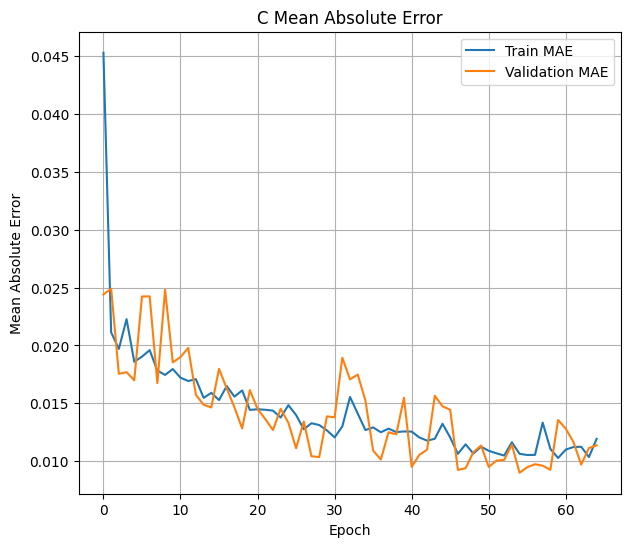

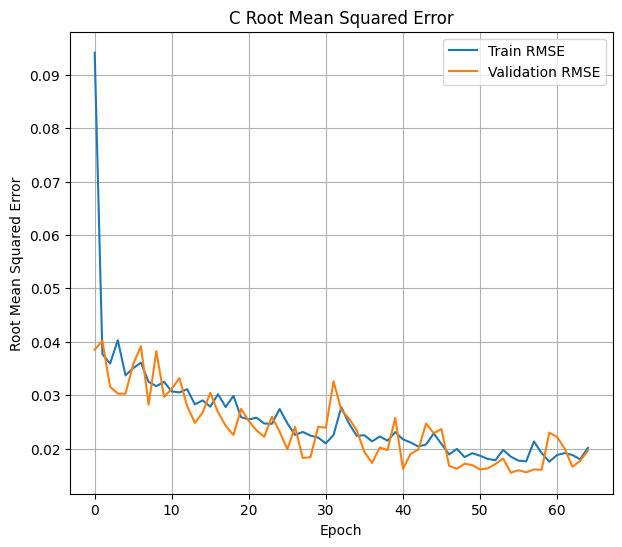

In [30]:
import matplotlib.pyplot as plt

# Assuming you have already trained the model and have the history object
# history = model.fit(...)  # This line is just a placeholder

# Plot training & validation Mean Absolute Error values
plt.figure(figsize=(7, 6))
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('C Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('mean_absolute_error.png', dpi=600)  # Save the figure at 600 DPI
plt.show()

# Plot training & validation Root Mean Squared Error values
plt.figure(figsize=(7, 6))
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('C Root Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('root_mean_squared_error.png', dpi=600)  # Save the figure at 600 DPI
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
Predicted Close Prices for the Next 5 Trading Days: [63.536987 62.81407  63.833572 63.459763 64.576195]


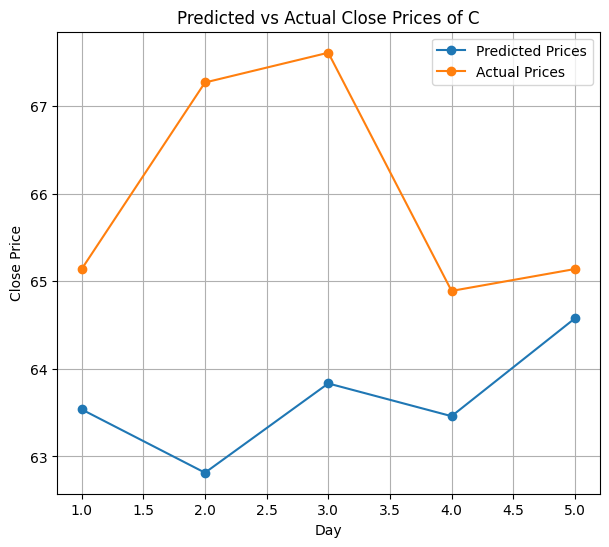

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the Attention layer and register it as a custom layer
@tf.keras.utils.register_keras_serializable()
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        e = tf.keras.backend.squeeze(e, axis=-1)
        alpha = tf.keras.backend.softmax(e)
        alpha = tf.keras.backend.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = tf.keras.backend.sum(context, axis=1)
        return context

# Function to make predictions for the next 5 days
def predict_next_5_days(model, data, seq_length, forecast_length):
    # Normalize the 'Close' column separately
    close_scaler = MinMaxScaler()
    data['Close'] = close_scaler.fit_transform(data[['Close']])
    
    # Normalize the rest of the data
    feature_scaler = MinMaxScaler()
    data[['Open', 'High', 'Low', 'Adj Close', 'Volume']] = feature_scaler.fit_transform(
        data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
    )
    
    # Prepare the most recent sequence
    recent_sequence = data.iloc[-seq_length:].copy()
    X_recent = np.array(recent_sequence[['Open', 'High', 'Low', 'Adj Close', 'Volume']])
    X_recent = np.expand_dims(X_recent, axis=0)  # Add batch dimension
    
    # Make predictions
    predictions = model.predict(X_recent)
    
    # Inverse transform the predictions
    predictions = close_scaler.inverse_transform(predictions)
    
    return predictions.flatten()

# Read data from "C.csv"
data = pd.read_csv("C.csv")

# Define parameters
SEQ_LENGTH = 60
FORECAST_LENGTH = 7  # The model was trained to predict the next 7 days

# Load the trained model
custom_objects = {
    'Attention': Attention,
    'mse': tf.keras.losses.MeanSquaredError()
}
model = tf.keras.models.load_model('c_model.h5', custom_objects=custom_objects)

# Predict the next 5 trading days
next_5_days_predictions = predict_next_5_days(model, data, SEQ_LENGTH, FORECAST_LENGTH)[:5]

# Print the predictions
print("Predicted Close Prices for the Next 5 Trading Days:", next_5_days_predictions)

# Read the actual test data from "C-test.csv"
test_data = pd.read_csv("C-test.csv")

# Assuming 'Close' is the column with actual closing prices
actual_prices = test_data['Close'].values[:5]

# Plot the predictions and actual values
plt.figure(figsize=(7, 6))
plt.plot(range(1, 6), next_5_days_predictions, marker='o', label='Predicted Prices')
plt.plot(range(1, 6), actual_prices, marker='o', label='Actual Prices')

plt.title('Predicted vs Actual Close Prices of C')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

   Day  Predicted Prices Predicted Trend  Actual Prices Actual Trend
0    1         63.536987            DOWN      65.139999         DOWN
1    2         62.814072            DOWN      67.269997           UP
2    3         63.833572              UP      67.610001           UP
3    4         63.459763            DOWN      64.889999         DOWN
4    5         64.576195              UP      65.139999           UP


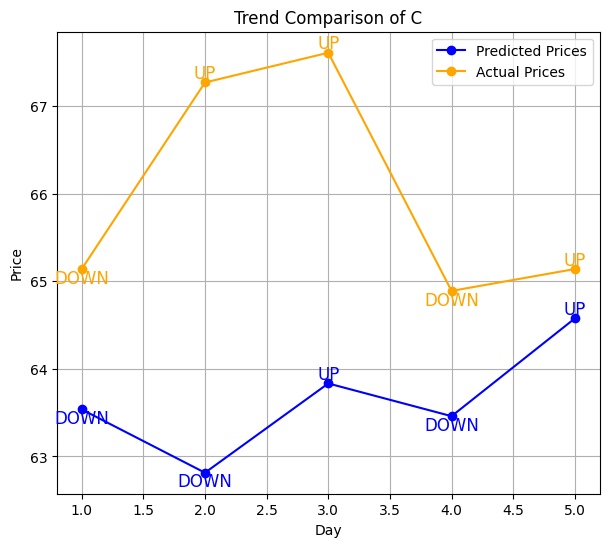

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the historical data
historical_data = pd.read_csv("ABBV.csv")
last_known_price = historical_data['Close'].iloc[-1]

# Function to generate trend labels
def generate_trend_labels(prices, start_value):
    trends = []
    previous_value = start_value
    for price in prices:
        if price > previous_value:
            trends.append("UP")
        else:
            trends.append("DOWN")
        previous_value = price
    return trends

# Generate trend labels for predictions and actual prices
predicted_trends = generate_trend_labels(next_5_days_predictions, last_known_price)
actual_trends = generate_trend_labels(actual_prices, last_known_price)

# Create a DataFrame to display the comparison
trend_comparison = pd.DataFrame({
    "Day": range(1, len(next_5_days_predictions) + 1),
    "Predicted Prices": next_5_days_predictions,
    "Predicted Trend": predicted_trends,
    "Actual Prices": actual_prices,
    "Actual Trend": actual_trends
})

# Display the comparison table
print(trend_comparison)

# Optionally, save the comparison table to a CSV file
trend_comparison.to_csv('trend_comparison.csv', index=False)

# Plot the trends for better visualization
plt.figure(figsize=(7, 6))
plt.plot(range(1, len(next_5_days_predictions) + 1), trend_comparison["Predicted Prices"], marker='o', label='Predicted Prices', color='blue')
plt.plot(range(1, len(next_5_days_predictions) + 1), trend_comparison["Actual Prices"], marker='o', label='Actual Prices', color='orange')

# Adding trend labels directly
for i in range(len(trend_comparison)):
    plt.text(i+1, trend_comparison["Predicted Prices"].iloc[i], 'UP' if trend_comparison["Predicted Trend"].iloc[i] == 'UP' else 'DOWN', 
             color='blue', fontsize=12, ha='center', va='bottom' if trend_comparison["Predicted Trend"].iloc[i] == 'UP' else 'top')
    plt.text(i+1, trend_comparison["Actual Prices"].iloc[i], 'UP' if trend_comparison["Actual Trend"].iloc[i] == 'UP' else 'DOWN', 
             color='orange', fontsize=12, ha='center', va='bottom' if trend_comparison["Actual Trend"].iloc[i] == 'UP' else 'top')

plt.title('Trend Comparison of C')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig('ctrend.png', dpi=600)
plt.show()